# CONFUSION Demo Notebook  

This notebook uses visual representations to check the the dimentions of each input and output.

Then, we test different methods for unpacking the linear layer at the end of the recurrent mechanism.

In [1]:
import numpy as np
import pandas as pd
import sys, os
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import talib as ta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# MAKE SURE WE HAVE THE ENVIRONMENT CONFIGURED PROPERLY
%cd ../src/main
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
if 'backend' not in os.listdir('.'):
    sys.path.insert(0, os.path.abspath(SCRIPT_DIR))

from backend.utils import DataIterGen_V2
from backend.technical_analysis import get_data_set_V2

/home/jackb/columbia/TFJ-DRL-update1/src/main


Getting CUDA

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device(f'cuda:{torch.cuda.device_count()-1}')
else:
    DEVICE = torch.device('cpu')

NAME = "conf_adhoc_"
ENV_SIZE = 128
DEVICE

device(type='cuda', index=0)

### Definining the recurrent attention (supervised) model

We will modify the feed-forward (`nn.Linear`) portion of the model to return the latent representation of the price at $t+1$

Before we have $W_1 \in \mathbb{R^{256 \times \text{env\_size}}}$, $W_2 \in \mathbb{R^{\text{env\_size} \times \text{1}}}$:

$$\hat{\text{price}}_{t+1} = RELU(W_1 \cdot (h_t \oplus \text{attention}(h_t)))W_2$$


To 'crack open' the model we will change its forward function to return the hidden vector $RELU(W_1 \cdot (h_t \oplus \text{attention}(h_t)))$. This is primarily what we will test on.

In [3]:
from backend.reinforcement_learning import tam

#define GRU class
#init parameter: env_size for RL algorithm
class GRU(nn.Module):
    def __init__(self, env_size):
        super(GRU, self).__init__()
        self.rnn=nn.GRU(
            input_size=86,
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )
        self.linear1=nn.Linear(256, env_size)
        self.linear2=nn.Linear(env_size, 1)
        self.num_layers=1
        
    def forward(self, x, state, device):
        batch_size,timestep, _=x.shape
        states, state=self.rnn(x, state)
        tamVec=tam(states, device)
        
        #concatVec: batch_size, time_step, hidden_size*2
        #i.e.       batch_size, 24       , 256        
        concatVec=torch.cat([states, tamVec],axis=2)
        envVec=self.linear1(torch.tanh(concatVec.reshape(batch_size*timestep, -1)))
        output=nn.Dropout(p=0.3)(envVec)
        output=nn.ReLU()(output)
        # hidden_output=nn.ReLU()(output) # HERE
        output=self.linear2(output)
        envVec=envVec.reshape(batch_size, timestep, -1)
        return (output.view(batch_size, -1), envVec), state#, hidden_output
  
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return torch.zeros((
                    self.rnn.num_layers, batch_size, 128), device=device)

tam_gru = GRU(env_size=ENV_SIZE).to(DEVICE)
tam_gru

GRU(
  (rnn): GRU(86, 128, batch_first=True)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

We need to redefine the `rlPolicy` agent as well. The `rlPolicy` agent is the one which recieves the loss at a given timestep $t$ during training, so it needs to pass that loss backwards to the `tam_gru` model as well.

Between the `tam_gru` model and policy agent we add a decoder model which reconstructs the `hidden_state` vector from the `hidden_output` vector.

To train the decoder, need a new loss function on top of the loss function from the paper. This new loss will be the angular difference between the `hidden_output` vector and the `predicted_hidden_output` vector. As we track this loss through time, it may clue us in to the `tam_gru` model's ability to represent the state. Higher loss means the `tam_gru` is treading uncharted territory, so to speak, which makes the policy agent ***confused***. This is how the decoder loss functions as a confusion metric for the model.

**This is ad-hoc, so we have one confusion for each timestep in the envVec**

In [4]:
class AutoEncoder(nn.Module):
    """Auto-encoder to get a latent representation of the hidden state, 
    then decode to get the confusion"""
    def __init__(self, env_size, device: torch.device):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
           nn.Linear(env_size, 64),
           nn.LeakyReLU(),
           nn.Dropout(p=0.3),
           nn.Linear(64, 16),
           nn.ReLU(),
           nn.Linear(16, 2)
        )


        self.decoder = nn.Sequential(
           nn.Linear(2, 16),
           nn.LeakyReLU(),
           nn.Dropout(p=0.3),
           nn.Linear(16, 64),
           nn.ReLU(),
           nn.Linear(64, env_size)
       )
       
        self.env_size = env_size
    
    def forward(self, x):
        # bsize = x.shape[0]
        # x = x.flatten(start_dim=1)
        hidden = self.encoder(x)
        output = self.decoder(hidden)
        # output = output.reshape(bsize, 24, self.env_size)
        # hidden = hidden.reshape(bsize, 1, 2)
        return hidden, output

decoder = AutoEncoder(ENV_SIZE, DEVICE).to(DEVICE)
decoder

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=128, bias=True)
  )
)

### Full Monty class

class extending nn.Module containing an instance of both the policy agent and gru-tam model.

Intended to make training easier to implement with PyTorch

In [5]:
from backend.reinforcement_learning import get_params, rlForwardFunc, rlPolicy

class full_monty(nn.Module):
    """RL Policy net modeled by parameters"""
    def __init__(self, env_size, device: torch.device):
        super(full_monty, self).__init__()
        
        #self.linear = nn.Linear(32+1, 1)
        
        W, b, h=get_params(env_size+1, device)
        self.device=device
        self.W=nn.Parameter(W)
        self.b=nn.Parameter(b)
        self.h=nn.Parameter(h)
        self.rnn=GRU(env_size)
        self.conf_net = AutoEncoder(env_size, device)

        self.device = device

    # Forward pass through the RL Policy network
    def forward(self, x, state):
        # Obtain predictions and environment vector from GRU
        (predP, envVec), state = self.rnn(x, state, self.device)
       
        # get the confusion
        envVec_copy = envVec.clone().detach()
        embed, reconstruction = self.conf_net(envVec_copy)
        bsize, tstep = reconstruction.shape[0], reconstruction.shape[1] 
        
        confusion_for_grad = nn.CosineEmbeddingLoss(reduction='none')(reconstruction.view((bsize*tstep, -1)), envVec_copy.view((bsize*tstep, -1)), torch.ones((bsize*tstep)).to(self.device))
        confusion=confusion_for_grad.clone().detach()
        confusion_for_grad = confusion_for_grad.mean() #nn.CosineEmbeddingLoss()(reconstruction.view((bsize*tstep, -1)), envVec_copy.view((bsize*tstep, -1)), torch.ones((bsize*tstep)).to(self.device))

        # Compute actions based on the environment vector and parameters
        rl_state = torch.concat((envVec, confusion.reshape(bsize, tstep, 1)), dim=2)
        output = rlForwardFunc(rl_state, [self.W, self.b, self.h])

        # Return predictions and actions
        return predP, output, (confusion, confusion_for_grad, embed)
    
    # Initialize the hidden state for the RL Policy network
    def begin_state(self, device, batch_size=1):
        return self.rnn.begin_state(device, batch_size)

combined = full_monty(ENV_SIZE, DEVICE)
combined

full_monty(
  (rnn): GRU(
    (rnn): GRU(86, 128, batch_first=True)
    (linear1): Linear(in_features=256, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conf_net): AutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=16, bias=True)
      (4): ReLU()
      (5): Linear(in_features=16, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=16, out_features=64, bias=True)
      (4): ReLU()
      (5): Linear(in_features=64, out_features=128, bias=True)
    )
  )
)

### Utility function defined in paper. 

$$R_t = \delta _t z_t - c|\delta_t - \delta_{t-1}| $$

$$U_t = \sum_{t=1}^T R_t$$

In [6]:
from backend.utils import calcUtility

In [7]:
from backend.utils import grad_clipping, init_weights, lossFunc, lossFunc2

# Define the new training function

Implicitly, we have 3 global models working together.

* `tam_gru`
* `decoder`
* `policy_agent`

In [8]:
#trainer for epoch
def train_epoch(train_iter, net, device, optim1, optim3, lossfn):
    loss_data=[]
    embed_list = []
    confusion_list = []
    with torch.autograd.set_detect_anomaly(True):
        for X, y, z, _ in train_iter:
            # reset state for each batch
            state= net.begin_state(batch_size=X.shape[0], device=device)
        
            # move to device
            X, y, z=X.to(device), y.to(device), z.to(device)
            
            # feed through full-monty
            predP, output, (_, confusion, embed) = net(X, state)
            
            # ============[ ADDING DECODER LOSS CONFUSION, DREAM] =====================
            optim3.zero_grad()
            confusion.backward()
            optim3.step()
            # =========================================================================

            loss = lossfn(predP, y, output,z, device)
            optim1.zero_grad()
            loss.backward()
            grad_clipping(net, 1)
            optim1.step()
            loss_data.append(loss.item())
    return np.array(loss_data).mean(), loss_data

In [9]:
#Testing on trained model
def prediction(eval_iter, net, device, lossfn):
    net.eval()
    net.conf_net.eval()
    loss_list=[]
    U_list=[]
    embed_list=[]
    conf_list=np.array([])
    with torch.no_grad():
        for X, y, z, _ in eval_iter:
            # to device
            X, y, z = X.to(device), y.to(device), z.to(device)

            # initialize rnn state
            state=net.begin_state(batch_size=X.shape[0], device=device) # changed from net.begin

            # feed through full-monty
            predP, output, (confusion,_, embed) = net(X, state)

            loss=lossfn(predP, y, output, z, device).float()
            U, _=calcUtility(output, z)
            loss_list.append(loss.cpu().numpy())
            U_list.append(U[:, -1].mean().cpu().numpy())
            embed_list.append(embed.flatten(0, 1).cpu().numpy())
            conf_list = np.concatenate((conf_list, confusion.flatten().cpu().numpy()))
    return np.array(loss_list).mean(), np.array(U_list).mean(), np.concatenate(embed_list), conf_list.mean()

In [10]:
import imageio
#Trainer 
#Incoporated learning rate scheduler
#Avg training loss & Avg validation Utility gain is recorded on epoch basis
#Loss and Utility by epoch are plotted at the end of training
def train(train_iter, eval_iter, net, optimizer1, optimizer2, device, num_epoch, name, lossfn=lossFunc2):
    loss_data=[]
    U_data=[]
    image_files = []
    os.makedirs('training_pics', exist_ok=True)
    net.apply(init_weights)
    net.to(device)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer1, 0.95, last_epoch=-1)

    for epoch in range(num_epoch):
        net.train()#, decoder.train()
        lossEpoch, lossEpoch_list =train_epoch(train_iter, net, device, optimizer1, optimizer2, lossfn=lossfn)   
        loss_v, U_v, embeds, confusion=prediction(eval_iter, net, device, lossfn=lossfn)
        loss_data.append(lossEpoch)  
        U_data.append(U_v)
        print(f'Epoch {epoch}, training loss: {lossEpoch:.2f}, val utility: {U_v:.2f}, confusion: {confusion:.3f}')
        plt.figure()
        x, y = embeds[:, 0], embeds[:, 1]
        plt.scatter(x,y, alpha=0.25)
        image_file = f"epoch_{epoch + 1}.png"
        plt.savefig('training_pics/'+image_file)
        plt.close()
        image_files.append(image_file)
        torch.save(net.state_dict(), os.path.join('./model_weights', f'{name}-epoch-{epoch+1}.pth'))
        #torch.save(decoder.state_dict(), os.path.join('./model_weights', f'{name}_decoder-{epoch+1}.pth'))
        scheduler.step()
    
     
    # Create GIF
    #plot gif of training process
    gif_file = 'training_progress.gif'
    with imageio.get_writer(gif_file, mode='I', duration=0.5) as writer:
        for image_file in image_files:
            image = imageio.imread('training_pics/'+image_file)
            writer.append_data(image)

    # Clean up images
    for image_file in image_files:
        os.remove('training_pics/'+image_file)

    #plot loss & Utility
    fig, ax_left = plt.subplots(figsize=(10,4))
    ax_right = ax_left.twinx()
    ax_left.plot(loss_data, label = "Loss", color='blue')
    ax_right.plot(U_data, label = "Utility", color='red')
    ax_left.set_xlabel('Time Step')
    ax_right.set_ylabel('Loss y axis')
    ax_right.set_ylabel('Utility y axis')
    ax_left.set_title('Loss and Utility')
    ax_left.legend()
    ax_right.legend()
    return loss_data

In [11]:
def test(net, test_iter, device, epoch, name):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    net.to(device)

    U_list=[]
    conf_list=np.array([])
    with torch.no_grad():
        for X, _, _, zp in test_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            output, envVec, (confusion, _, embed) = net(X, state)
            U, _=calcUtility(output, zp)
            U_list.append(U[:, -1].mean().cpu().numpy())

            #== [confusion] ==
            conf_list = np.append(conf_list, confusion.flatten().cpu().numpy())
            # ===============
    return np.array(U_list).mean(), conf_list.mean()

In [12]:
def demo(net: torch.nn.Module, demo_iter:torch.utils.data.DataLoader, device: torch.device, epoch, name,
         title='TFJ-DRL With Confusion'):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    net.to(device)
    
    reward=np.array([])
    conf_list=np.array([])
    stock_change=np.array([])
    with torch.no_grad():
        for X, _, _, zp in demo_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            output, envVec, (confusion, _, embed) = net(X, state)
            discretizedAction=((output>=0)*2-1)
            batchReward=discretizedAction*zp
            reward=np.concatenate((reward,batchReward[:,-1].reshape(-1).cpu().numpy()))
            stock_change=np.concatenate((stock_change, zp[:,-1].reshape(-1).cpu().numpy()))
            
            #== [confusion] ==
            conf_list = np.concatenate((conf_list, confusion.reshape(X.shape[0], -1).mean(dim=-1).cpu().numpy()))
            # ===============
            
        result = [sum(reward[ : i + 1]) for i in range(len(reward))] 
    return result, conf_list, stock_change

def show_demo(result, conf_list, stock_change, baseline):
    if baseline:
        fig, [underlying, base, ax_left, ax_right] = plt.subplots(4, figsize=(20,15), sharex=True)
        base.plot(baseline, label = "Baseline Stock Gain", color='blue')
        base.set_ylabel("Cumulative Gain")
        base.hlines([0], 0, 1, transform=base.get_yaxis_transform(), linestyle='dashed', colors='gray')
        base.legend()
    else:
        fig, [underlying, ax_left, ax_right] = plt.subplots(3, figsize=(20,12), sharex=True)
    ax_left.plot(result, label = "Stock Gain", color='blue')
    ax_left.hlines([0], 0, 1, transform=ax_left.get_yaxis_transform(), linestyle='dashed', colors='gray')
    ax_left.set_xlabel('Time Step')
    ax_left.set_ylabel('Cumulative Gain')
    ax_right.set_ylabel('Confusion')
    ax_right.plot(conf_list, label='Confusion at Time Step')
    ax_left.set_title('TFJ-DRL With Confusion')
    underlying.set_title('Underlying Stock Movement')
    underlying.plot(np.cumsum(stock_change), label="Closing Price", color='blue')
    underlying.hlines([0], 0, 1, transform=underlying.get_yaxis_transform(), linestyle='dashed', colors='gray')
    ax_left.legend()
    ax_right.legend()
    underlying.legend()
    return 

# Train, Test and Demo with Cooper Companies Inc.

In [13]:
stockList1=['COO','COF','ABBV','CCL','AMD','GOOG',
            'ABT','ACN','ADBE','AES','NVDA',
            'AIG','ALL', 'AMG','AMZN','APA','AAPL',
            'AXP','BA','BBY','CAT','GE', 'CSCO', 
            'EA','EQR','FCX','FE',
            'HST','IBM','INTC','JCI','MMM','MO',
            'ORCL','PPL','T','EXPD','VMC','VNO']

Using periods
Train: ('2013-01-01', '2017-10-01')
Test: ('2018-01-01', '2019-01-01')
Validation: ('2017-10-08', '2018-04-01')
Initializing Training Dataset...[DONE]
Initializing Iterators(dataloaders) From Dataset...[DONE]
Stock ticker: COO
Epoch 0, training loss: 2.32, val utility: 2.31, confusion: 0.922
Epoch 1, training loss: 2.15, val utility: 2.57, confusion: 0.880
Epoch 2, training loss: 1.96, val utility: 3.02, confusion: 0.843
Epoch 3, training loss: 1.87, val utility: 3.91, confusion: 0.811
Epoch 4, training loss: 1.69, val utility: 3.76, confusion: 0.781
Epoch 5, training loss: 1.61, val utility: 3.99, confusion: 0.752
Epoch 6, training loss: 1.47, val utility: 3.88, confusion: 0.726
Epoch 7, training loss: 1.39, val utility: 3.70, confusion: 0.700
Epoch 8, training loss: 1.18, val utility: 3.56, confusion: 0.675
Epoch 9, training loss: 1.12, val utility: 4.01, confusion: 0.652
Epoch 10, training loss: 1.03, val utility: 3.29, confusion: 0.632
Epoch 11, training loss: 1.01, v

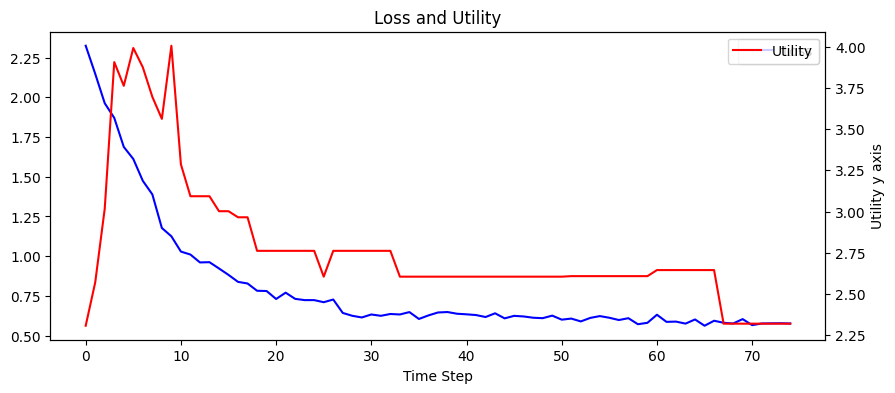

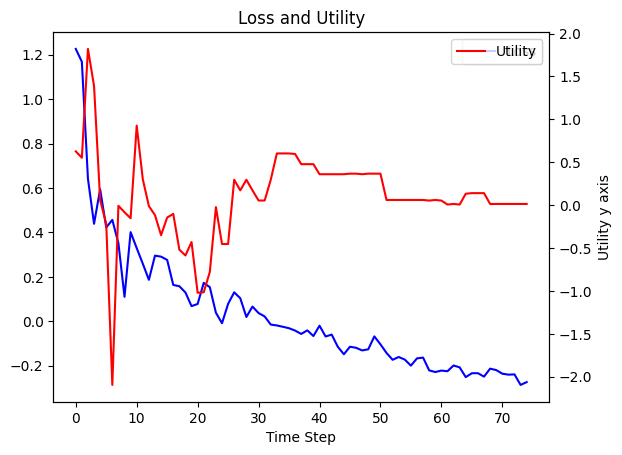

In [17]:
from backend.baseline_functions import train as train_, demo as demo_
# Get Iterators
train_iter, val_iter, test_iter = DataIterGen_V2(0, stockList1, demo=False)
# Training for COO 
os.makedirs('./model_weights', exist_ok=True)
TFJDRLconf_COO = full_monty(device=DEVICE, env_size=ENV_SIZE)
MAX_EPOCH = 75
optim1 = optim.Adam(TFJDRLconf_COO.parameters(),            lr=0.0001, weight_decay=0.01)
optim2 = optim.Adam(TFJDRLconf_COO.conf_net.parameters(),   lr=0.001, weight_decay=0.01)
loss=train(train_iter, val_iter, net=TFJDRLconf_COO,
           optimizer1=optim1, optimizer2=optim2, device=DEVICE, num_epoch=MAX_EPOCH,
           name=NAME+'COO')
# baseline model for comparison
TFJDRLbase_COO = rlPolicy(device=DEVICE, env_size=ENV_SIZE)
optim3 = optim.Adam(TFJDRLbase_COO.parameters(), lr=0.001, weight_decay=0.01)
loss2=train_(TFJDRLbase_COO, train_iter, val_iter, optim3, DEVICE, MAX_EPOCH, name='TFJDRLbase_COO')

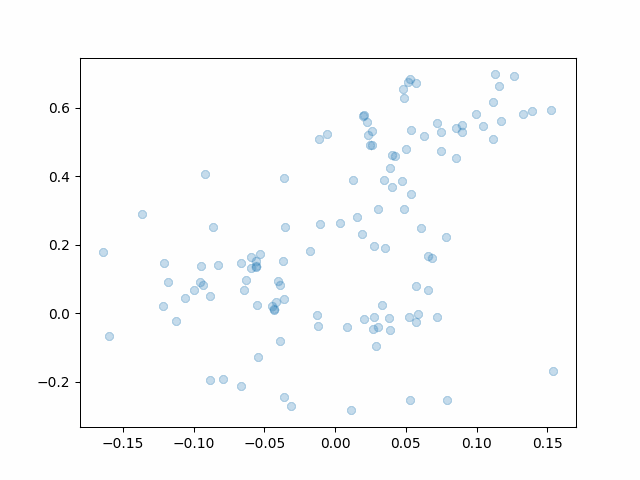

In [18]:
# display gif learning feature representations
from IPython.display import display, Image
display(Image(filename='training_progress.gif'))

On average, every 24 days the algorithm yields: -4.77
The average confusion level is: 0.349
Using periods
Train: ('2013-01-01', '2017-10-01')
Test: ('2018-01-01', '2019-01-01')
Validation: ('2017-10-08', '2018-04-01')
Initializing Training Dataset...[DONE]
Demo Stock ticker: COO, change in closing price during testing period: $6.03


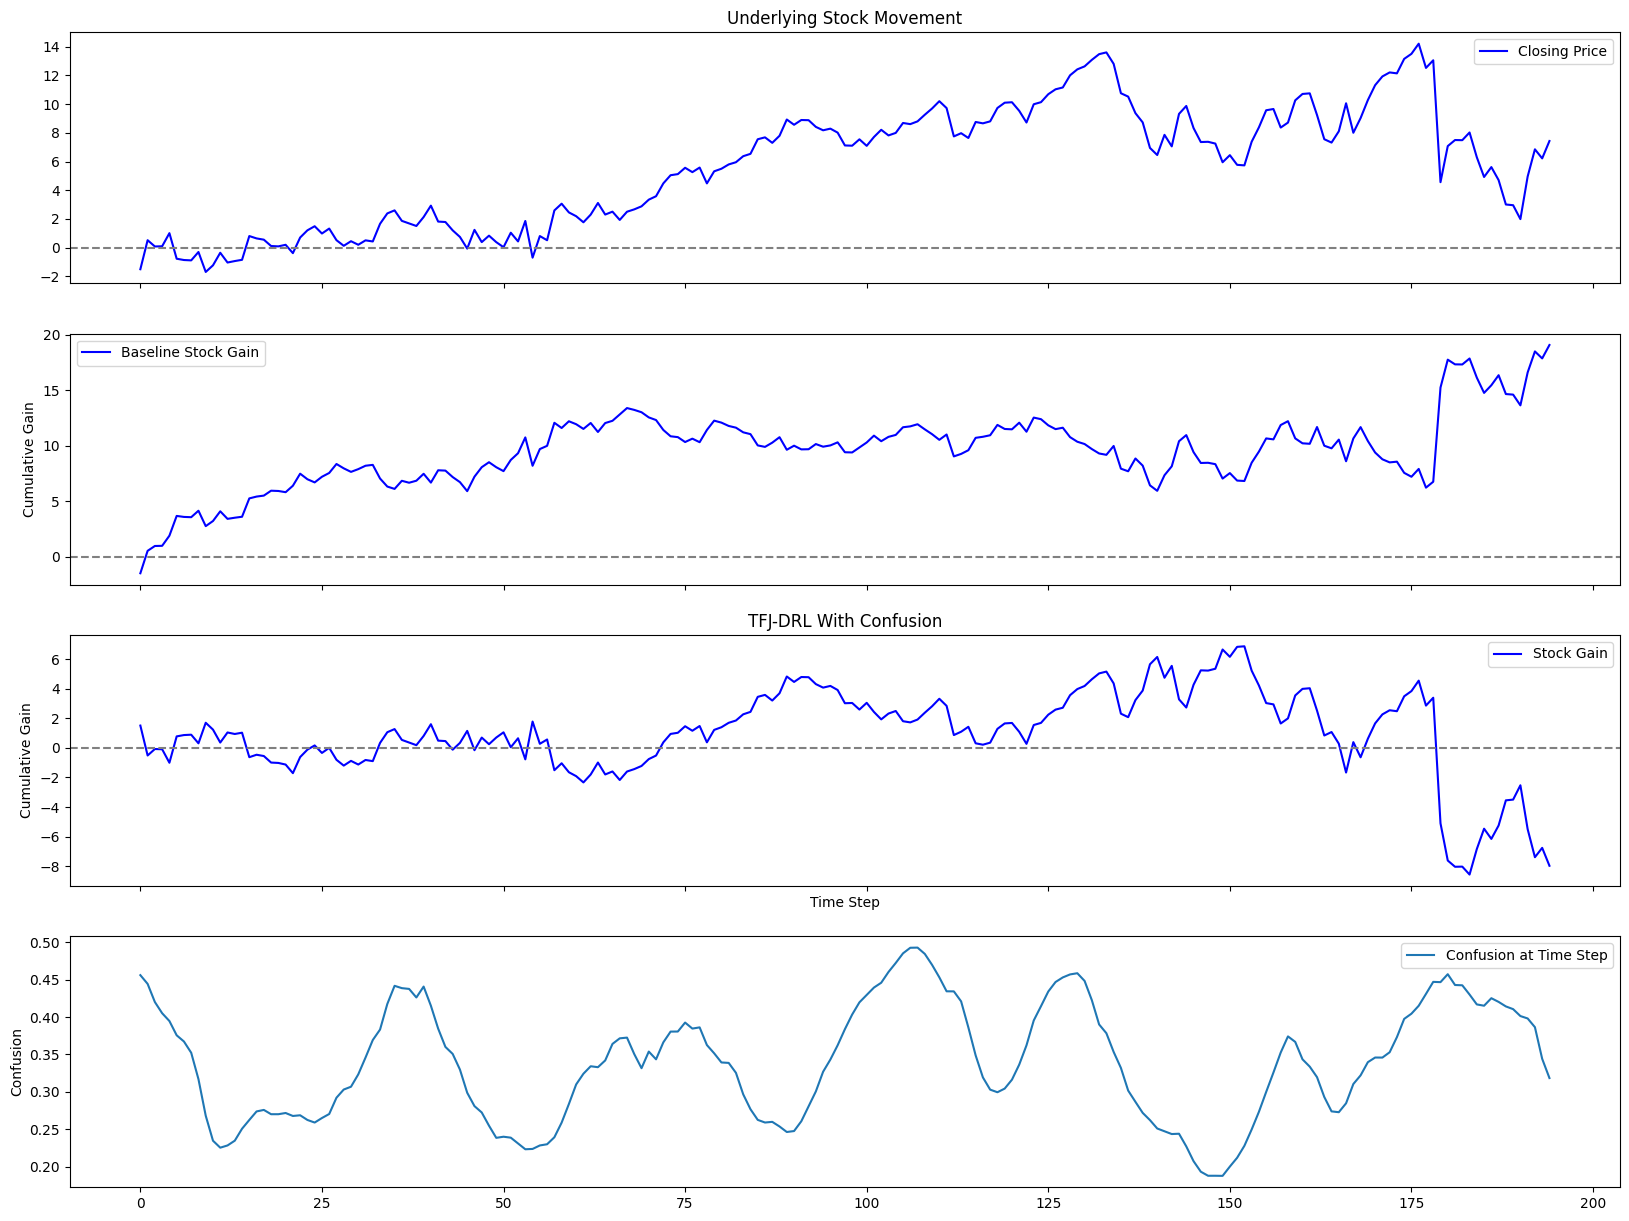

In [19]:
avgReturn, avgConf=test(net=TFJDRLconf_COO, test_iter=test_iter, device=DEVICE, epoch=MAX_EPOCH, name=NAME+'COO')
print(f'On average, every 24 days the algorithm yields: {avgReturn:.2f}' )
print(f'The average confusion level is: {avgConf:.3f}')
demo_iter = DataIterGen_V2(0, stockList1, demo=True)
test_result, conf, stock_change = demo(net=TFJDRLconf_COO, demo_iter=demo_iter, device=DEVICE, epoch=MAX_EPOCH , name=NAME+'COO')
baseReturn = demo_(net=TFJDRLbase_COO, demo_iter=demo_iter, device=DEVICE, epoch=MAX_EPOCH, name='TFJDRLbase_COO')
show_demo(result=test_result, stock_change=stock_change, baseline=baseReturn, conf_list=conf)

# Train, Test and Demo with Capital One Financial Corp.